DSCI100 002, Group 18

Group Members: Jimmy Choy, Jennifer Law, Heather Lu, Elise Wong



#### **TITLE: Sleep Disorder Diagnosis**

#### **INTRODUCTION**

Sleep is fundamental to human life and health, but many people suffer from sleep disorders. Two sleep disorders are sleep apnea–where breathing stops during sleep–and insomnia, where people have difficulty falling asleep [1]. Sleep disorders can be influenced by lifestyle, particularly stress and physical activity [2]. They are also often comorbid with chronic health disorders, such as heart diseases and mental illnesses [1].

In our project, we utilized the Sleep Health and Lifestyle Dataset, which includes information pertaining to sleep, lifestyle, physical health, and sleep disorders [3]. It includes eleven variables: gender, age, occupation, sleep duration, quality of sleep, physical activity level, stress level, BMI category, blood pressure, heart rate, daily steps, and diagnosis. The ‘diagnosis’ variable is the predictor variable and has three possible values: sleep apnea, insomnia, and no sleep disorder.
Using the dataset, we aimed to determine: “How can lifestyle and physiological measures be used to predict the absence or presence of sleep disorders?” To do this, we predicted the diagnosis (sleep disorder or none) via classification as the diagnosis variable is categorical.


#### **METHODS & RESULTS** 


#### **Exploratory Data Analysis**

For our analysis, the packages below are needed to run the code. The seed is set to 100 for reproducibility.

In [2]:
library(tidyverse)
library(tidymodels) #for classification analysis
library(GGally) #for ggpairs
library(cowplot) #for plot_grid

set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We read the dataset in via a url with a comma as the delimiter.

In [3]:
url <- "https://drive.google.com/uc?export=download&id=1oltvINJVaLEg0raTdWG2IoFCf6w4h5vD"
sleep_data <- read_delim(url,
                         delim = ",")
head(sleep_data)

Rows: 374 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder
dbl (8): Person ID, Age, Sleep Duration, Quality of Sleep, Physical Activity...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


#### **Cleaning & Wrangling**

As the original column headers contained blank spaces in between words, we added a period to replace these spaces using colnames.

In [4]:
#adding a period to replace spaces in the headers
colnames(sleep_data) <- make.names(colnames(sleep_data))

Our model excluded "Gender", "Occupation" and “BMI category”. We observed imbalanced proportions in these variables, which would introduce bias to the model’s performance. They were also excluded because they are factor variables. We restricted our predictors to only numerical variables for consistency in analysis. “Person ID” was also excluded as it labels each observation and should not be used as a predictor. The "Blood Pressure" variable was divided into systolic and diastolic variables to ensure that each cell contains one value only.

In [5]:
#separating bp column
sleep_data <- separate(sleep_data,
    col = Blood.Pressure,
    into = c("Systolic.BP", "Diastolic.BP"),
    sep = "/",
    convert = TRUE) 

In [6]:
#removing unwanted predictors
sleep_data_2 <- sleep_data |>
    select(-Person.ID, -Gender, -Occupation, -BMI.Category)
head(sleep_data_2)

Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Sleep.Disorder
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
27,6.1,6,42,6,126,83,77,4200,None
28,6.2,6,60,8,125,80,75,10000,None
28,6.2,6,60,8,125,80,75,10000,None
28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
28,5.9,4,30,8,140,90,85,3000,Sleep Apnea
28,5.9,4,30,8,140,90,85,3000,Insomnia


“Insomnia” and “sleep apnea” were combined to a single value, “Sleep Disorder”, in the Diagnosis column so that the number of subjects with a sleep disorder is similar to the number of subjects without one.

In [7]:
#combining 'sleep apnea' and 'insomnia' into 'sleep disorders'
sleep_apnea_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Sleep Apnea") |>
select(-Sleep.Disorder)
sleep_apnea_tidy <- data.frame(sleep_apnea_untidy, Diagnosis = "Sleep Disorder")

insomnia_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "Insomnia") |>
select(-Sleep.Disorder)
insomnia_tidy <- data.frame(insomnia_untidy, Diagnosis = "Sleep Disorder")

none_untidy <- sleep_data_2 |>
filter(Sleep.Disorder == "None") |>
select(-Sleep.Disorder)
none_tidy <- data.frame(none_untidy, Diagnosis = "None")

tidy_sleep_data <- rbind(sleep_apnea_tidy, insomnia_tidy, none_tidy)

head(tidy_sleep_data)

,Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps,Diagnosis
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
1,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
2,28,5.9,4,30,8,140,90,85,3000,Sleep Disorder
3,29,6.5,5,40,7,132,87,80,4000,Sleep Disorder
4,29,6.0,6,30,8,120,80,70,8000,Sleep Disorder
5,30,6.4,5,35,7,130,86,78,4100,Sleep Disorder
6,31,7.7,7,75,6,120,80,70,8000,Sleep Disorder


**Table 1: Summary Count**

The table below represents the number of observations and percentages for each class in the training set.

In [8]:
summary_table_1 <- tidy_sleep_data |>
  group_by(Diagnosis) |>
  summarize(count = n(), percentage = n()/nrow(tidy_sleep_data)*100)

summary_table_1

Diagnosis,count,percentage
<chr>,<int>,<dbl>
None,219,58.55615
Sleep Disorder,155,41.44385


**Table 2: Summary Means**

The table below represents the means for each predictor in the training set.

In [9]:
summary_table_2 <- summarize(tidy_sleep_data, across(Age:Daily.Steps, mean))
summary_table_2

Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42.18449,7.132086,7.312834,59.17112,5.385027,128.5535,84.64973,70.16578,6816.845


**Table 3: Summary Means Diagnosis**

The table below shows the means for each predictor in the training set, split between diagnosis.

In [10]:
summary_table_3 <- tidy_sleep_data |>
    group_by(Diagnosis) |>
    summarize(across(Age:Daily.Steps, mean))

summary_table_3

Diagnosis,Age,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,Systolic.BP,Diastolic.BP,Heart.Rate,Daily.Steps
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
None,39.03653,7.358447,7.625571,57.94977,5.114155,124.0457,81.00000,69.01826,6852.968
Sleep Disorder,46.63226,6.812258,6.870968,60.89677,5.767742,134.9226,89.80645,71.78710,6765.806


**Figure 1: Exploratory Visualization**

A ggpairs plot was used to compare the "Sleep Disorder" and "None" observations against each predictor variable.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



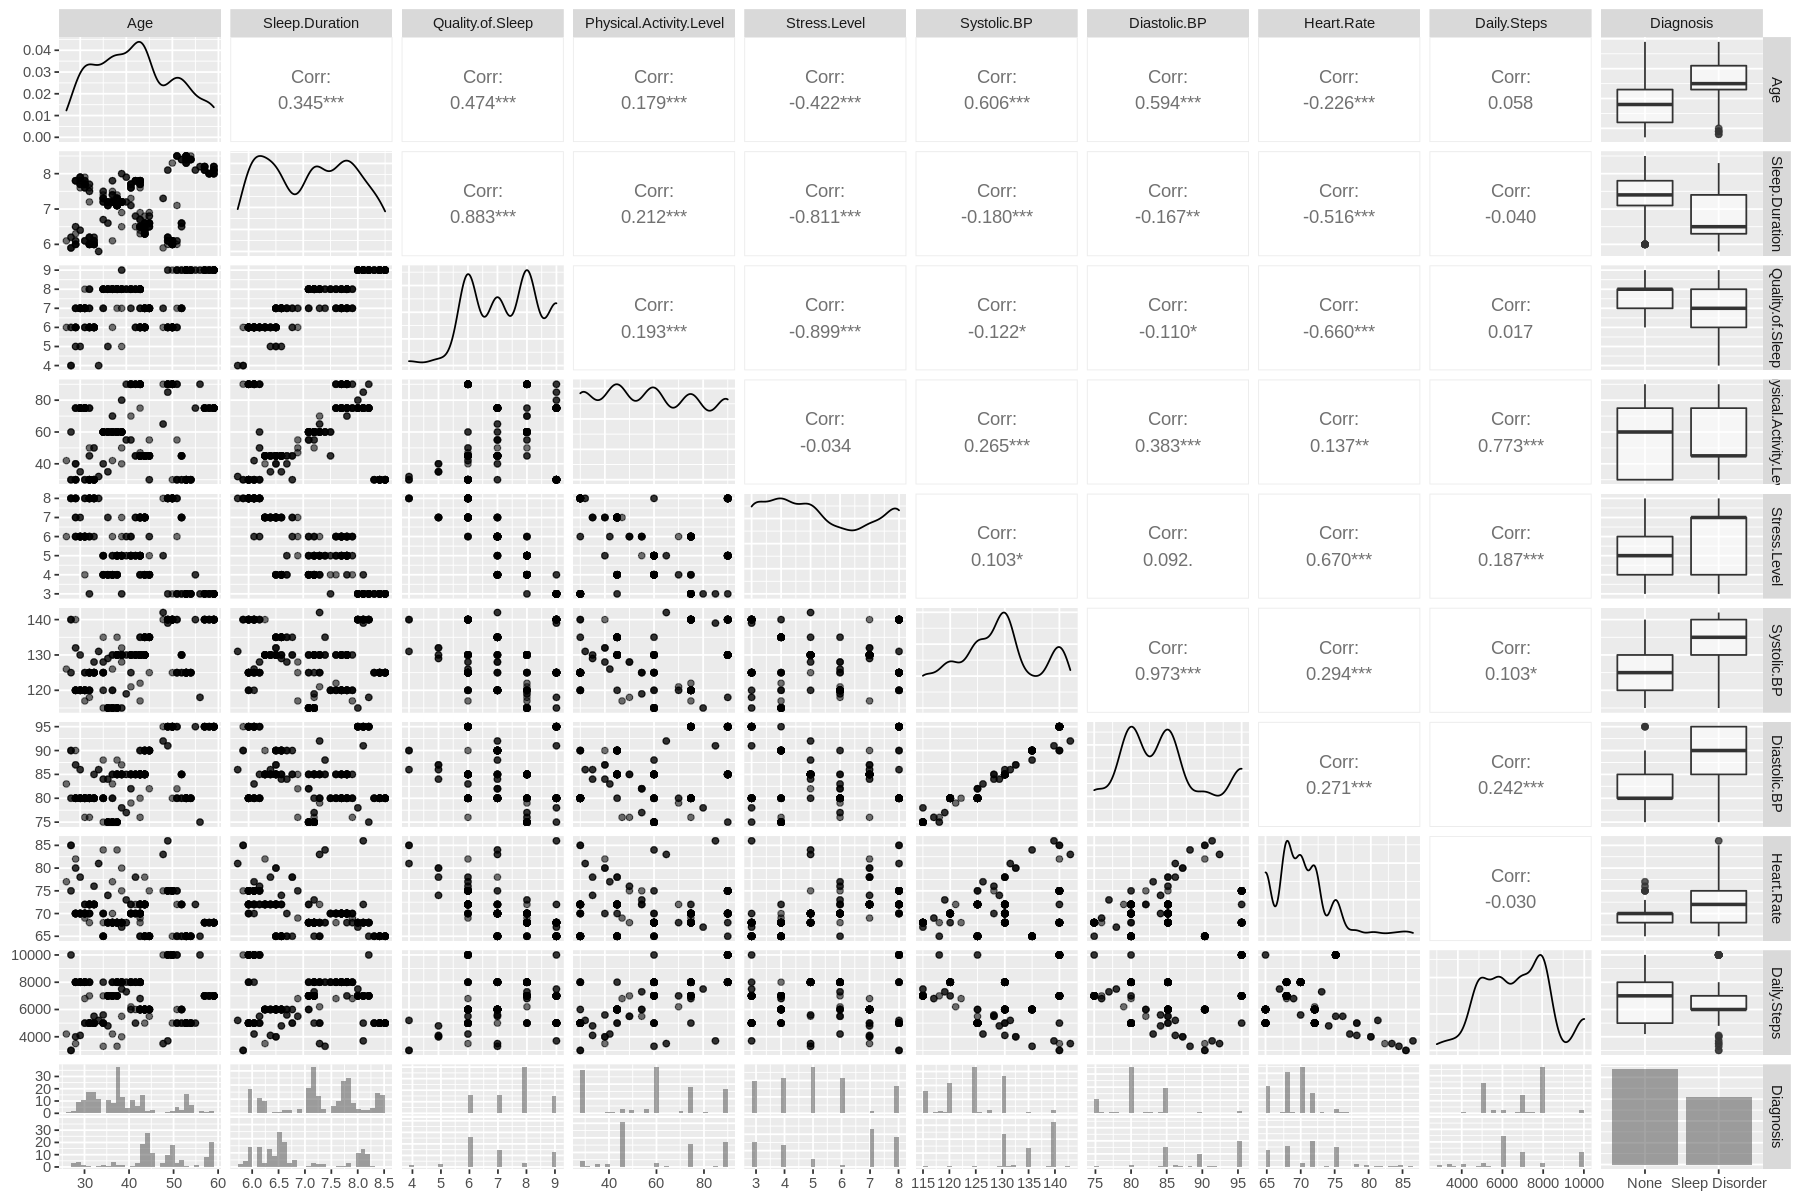

In [11]:
options(repr.plot.width=15, repr.plot.height=10)
comparison_plot <- tidy_sleep_data |>
    ggpairs(mapping = aes(alpha = 0.4))

comparison_plot

> **Figure 1 Legend** \
Each variable in the sleep dataset is plotted against each other to visualize the relationships in scatterplots, line graphs, box plot, bar graph, and correlation coefficient formats. The box plots were used to compare the median and range of the diagnoses for each variable to identify the best predictors. We defined the ideal predictor for our data analysis as having a noticeable difference between the two classification categories in Diagnosis. 

**Table 4: Chosen Predictor Variables**

Age, Sleep Duration, and Systolic and Diastolic blood pressure were chosen as the predictors for our analysis because these variables showed the largest difference between diagnoses, based on the boxplots from Figure 1 and the difference in means from Table 3.

In [12]:
final_sleep_data <- tidy_sleep_data |>
    select(Age, Sleep.Duration, Systolic.BP, Diastolic.BP, Diagnosis)

head(final_sleep_data)

,Age,Sleep.Duration,Systolic.BP,Diastolic.BP,Diagnosis
,<dbl>,<dbl>,<int>,<int>,<chr>
1,28,5.9,140,90,Sleep Disorder
2,28,5.9,140,90,Sleep Disorder
3,29,6.5,132,87,Sleep Disorder
4,29,6.0,120,80,Sleep Disorder
5,30,6.4,130,86,Sleep Disorder
6,31,7.7,120,80,Sleep Disorder


> **Table 4 Legend** \
A tibble containing our chosen predictor variables (Age, Sleep duration, Systolic and Diastolic blood pressure) and the target variable (Diagnosis).

**Table 5:  Label Variable As Factor**

To use our target variable in classification analysis, we changed its class from character to factor.

In [13]:
final_sleep_data <- final_sleep_data |>
    mutate(Diagnosis = as_factor(Diagnosis))
head(final_sleep_data)

,Age,Sleep.Duration,Systolic.BP,Diastolic.BP,Diagnosis
,<dbl>,<dbl>,<int>,<int>,<fct>
1,28,5.9,140,90,Sleep Disorder
2,28,5.9,140,90,Sleep Disorder
3,29,6.5,132,87,Sleep Disorder
4,29,6.0,120,80,Sleep Disorder
5,30,6.4,130,86,Sleep Disorder
6,31,7.7,120,80,Sleep Disorder


> **Table 5 Legend** \
The final data frame of our target and predictor variables used for classification analysis.

#### **Data Analysis**

The sleep dataset was first split into a training and testing set.

In [14]:
sleep_split <- initial_split(final_sleep_data, prop = 0.75, strata = Diagnosis)
sleep_train <- training(sleep_split)
sleep_test <- testing(sleep_split)

**Figure 2: Predictor Variables Comparisons**

To look at the correlation between our predictor variables, we plotted them against each other as scatterplots. Ideally, the predictor variables should not overlap/correlate (i.e. we should not see a straight line). Based on our plots, we see that age does not correlate with diastolic blood pressure nor sleep duration. Sleep duration also does not overlap with systolic blood pressure. However, we see that there is almost a perfect positive correlation between systolic and diastolic blood pressure. While this might become an issue in later analysis, we decided to keep both blood pressures as both are equally important in predicting health outcomes and in real life, both values are analyzed simultaneously.

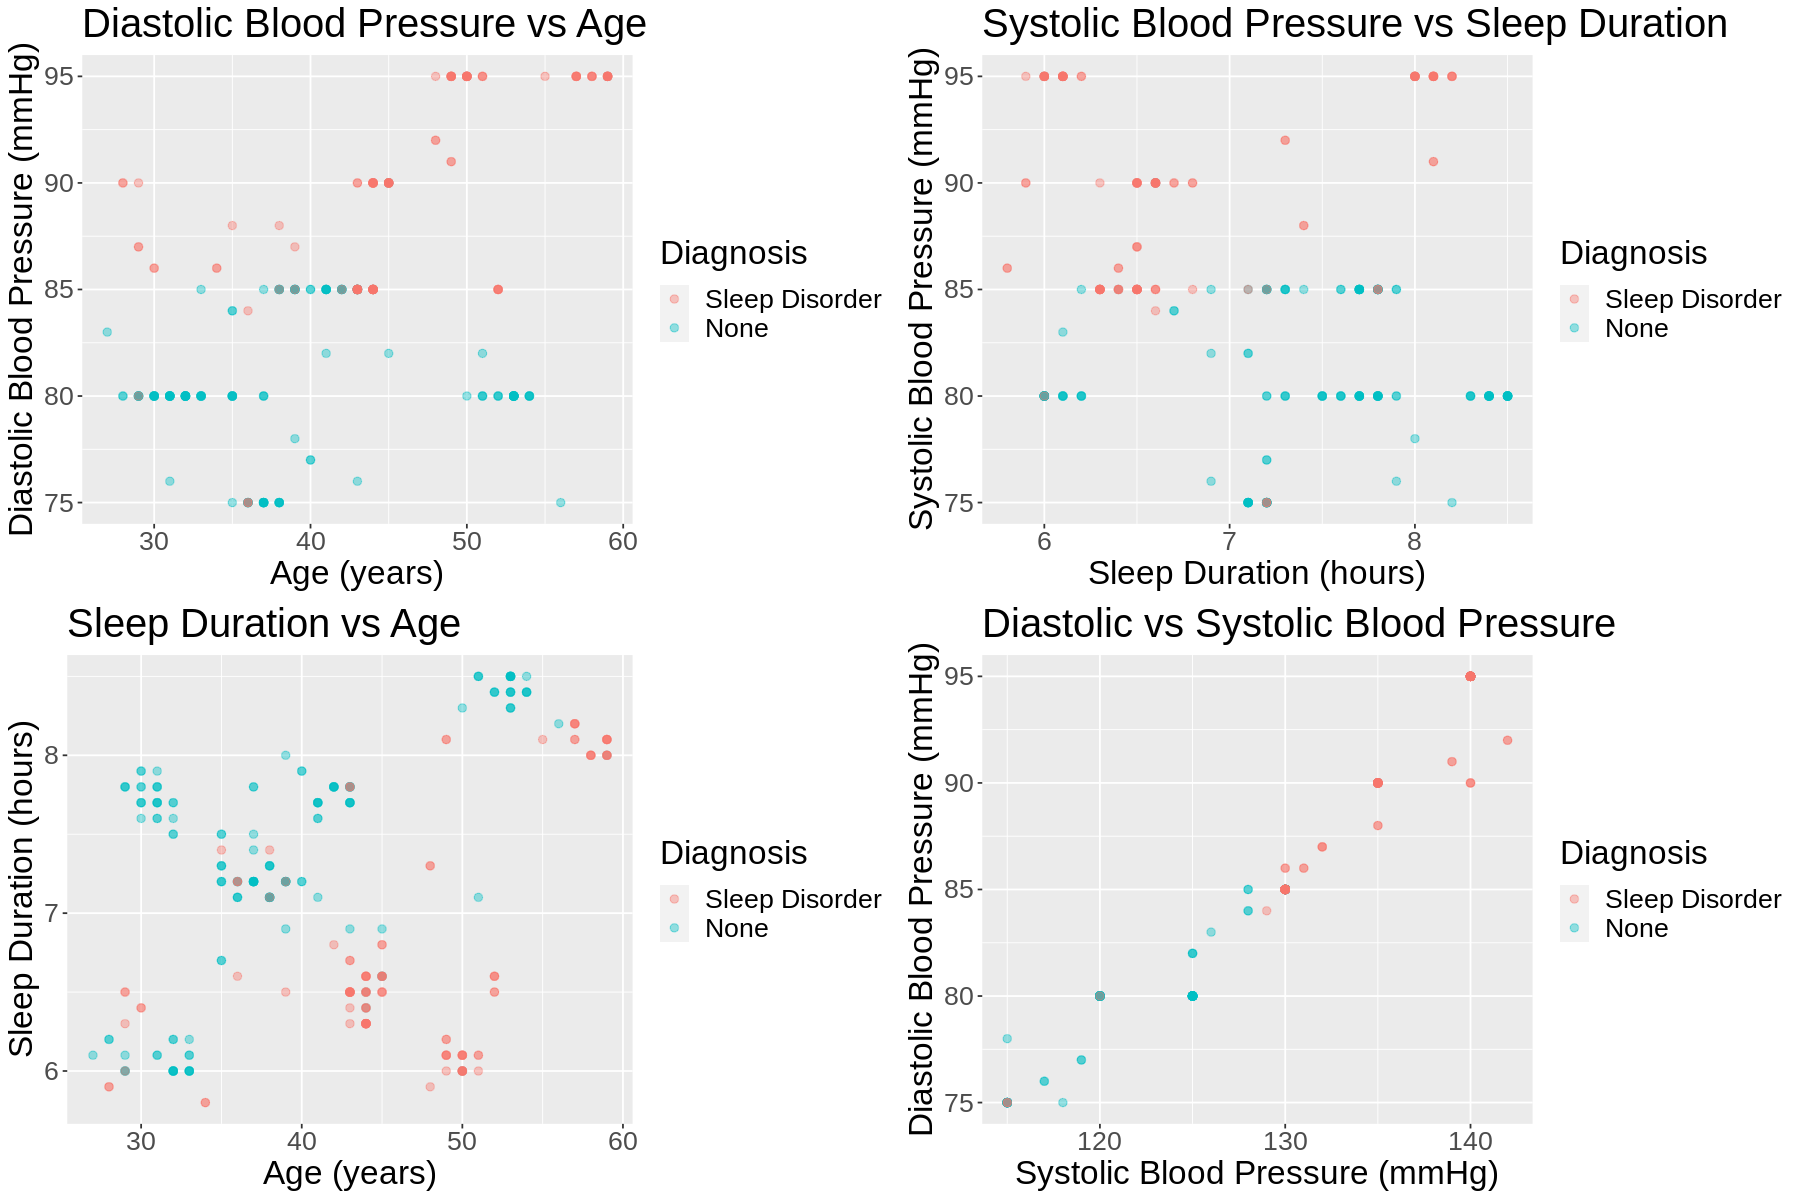

In [15]:
Age_Diastolic <- sleep_train |>
ggplot(aes(x = Age, y = Diastolic.BP, colour = Diagnosis)) +
geom_point(size = 2, alpha = 0.4) +
labs(x = "Age (years)", y = "Diastolic Blood Pressure (mmHg)", colour = "Diagnosis") +
ggtitle("Diastolic Blood Pressure vs Age") +
theme(text = element_text(size = 20))

Systolic_Sleep <- sleep_train |>
ggplot(aes(x = Sleep.Duration, y = Diastolic.BP, colour = Diagnosis)) +
geom_point(size = 2, alpha = 0.4) +
labs(x = "Sleep Duration (hours)", y = "Systolic Blood Pressure (mmHg)",
    colour = "Diagnosis") +
ggtitle("Systolic Blood Pressure vs Sleep Duration") +
theme(text = element_text(size = 20))

Systolic_Diastolic <- sleep_train |>
ggplot(aes(x = Systolic.BP, y = Diastolic.BP, colour = Diagnosis)) +
geom_point(size = 2, alpha = 0.4) +
labs(x = "Systolic Blood Pressure (mmHg)", y = "Diastolic Blood Pressure (mmHg)",
    colour = "Diagnosis") +
ggtitle("Diastolic vs Systolic Blood Pressure") +
theme(text = element_text(size = 20))

Age_Sleep <- sleep_train |>
ggplot(aes(x = Age, y = Sleep.Duration, colour = Diagnosis)) +
geom_point(size = 2, alpha = 0.4) +
labs(x = "Age (years)", y = "Sleep Duration (hours)",
    colour = "Diagnosis") +
ggtitle("Sleep Duration vs Age") +
theme(text = element_text(size = 20))

plot_grid(Age_Diastolic, Systolic_Sleep, Age_Sleep, Systolic_Diastolic, ncol = 2)

> **Figure 2 Legend** \
 Four scatterplots plotting our four predictor variables against each other using the training set, with diagnosis colour-coding the observations.

The training set was used to create a model specification and recipe for the model.

In [16]:
sleep_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
sleep_recipe <- recipe(Diagnosis ~ ., data = sleep_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

We created the splits for a 5-fold cross-validation.

In [17]:
sleep_vfold <- vfold_cv(sleep_train, v = 5, strata = Diagnosis)

K values 1 to 15 were selected and stored in a data frame to analyze in the subsequent workflow analysis.

In [18]:
kgrid <- tibble(neighbors = seq(1:15))
sleep_workflow <- workflow() |>
    add_recipe(sleep_recipe) |>
    add_model(sleep_spec) |>
    tune_grid(resamples = sleep_vfold, grid = kgrid) |>
    collect_metrics()

**Figure 3: K Accuracy Visualization**

The workflow was filtered to extract only the "accuracy" rows, and this object was plotted to visualize the accuracy of each selected K value.

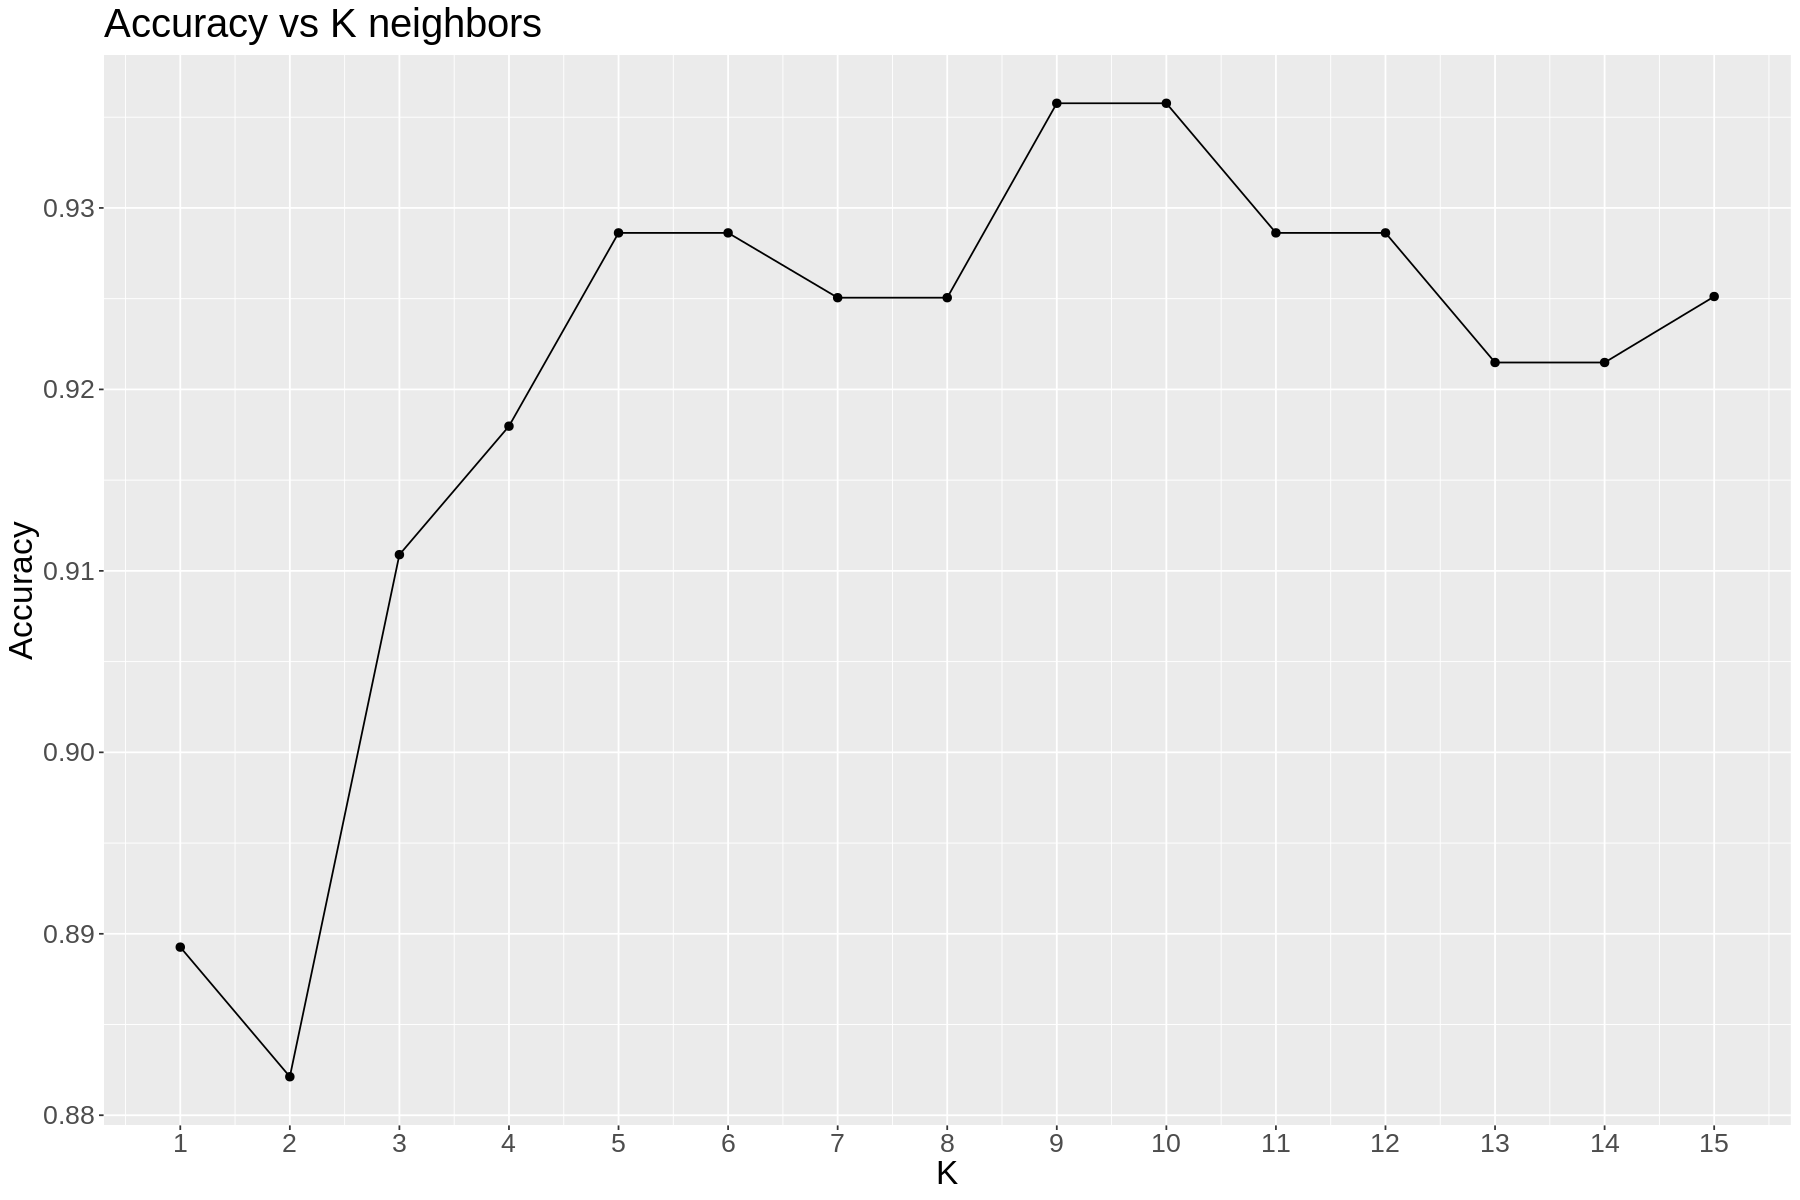

In [19]:
sleep_accuracy <- sleep_workflow |>
    filter(.metric == "accuracy")

sleep_accuracy_plot <- sleep_accuracy |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point(size = 2) +
    geom_line() +
    labs(x = "K", y = "Accuracy") +
    ggtitle("Accuracy vs K neighbors") +
    scale_x_continuous(breaks = 1:15) +
    theme(text = element_text(size = 20))

sleep_accuracy_plot

> **Figure 3 Legend** \
Accuracy vs K neighbors line graph. The y-axis shows the accuracy of each K value on the x-axis. The optimal K value is that which scores the highest accuracy. Based on the plot, the best K value is 13. While both 13 and 14 have the same highest accuracy (0.93), a smaller K value will process faster, which is ideal.

The final model was made using the chosen K value. The model was then fitted on the training set.

In [20]:
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
    set_engine("kknn") |>
    set_mode("classification")
fit_sleep <- workflow() |>
    add_recipe(sleep_recipe) |>
    add_model(final_spec) |>
    fit(data = sleep_train)

**Table 6: Fitted Data**

The final model was used to predict Diagnosis on the testing set.

In [21]:
predict_sleep <- predict(fit_sleep, sleep_test) |>
    bind_cols(sleep_test)
head(predict_sleep)

.pred_class,Age,Sleep.Duration,Systolic.BP,Diastolic.BP,Diagnosis
<fct>,<dbl>,<dbl>,<int>,<int>,<fct>
None,31,7.7,120,80,Sleep Disorder
None,36,6.6,129,84,Sleep Disorder
Sleep Disorder,42,6.8,130,85,Sleep Disorder
Sleep Disorder,49,6.2,140,95,Sleep Disorder
Sleep Disorder,50,6.1,140,95,Sleep Disorder
Sleep Disorder,50,6.0,140,95,Sleep Disorder


> **Table 6 Legend**\
The tibble shows a handful of observations with predicted labels in the testing data set using the model created prior.

Below is the confusion matrix that shows the number of correct predicted labels against the true labels.

In [22]:
confusion_matrix <- predict_sleep |>
    conf_mat(truth = Diagnosis, estimate = .pred_class)

confusion_matrix

                Truth
Prediction       Sleep Disorder None
  Sleep Disorder             33    4
  None                        6   51

Finally, we calculated the accuracy of our final model.

In [118]:
final_accuracy <- predict_sleep |>
    metrics(truth = Diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

final_accuracy

[1] 0.9468085

#### **DISCUSSION**

From our accuracy versus K plot (Figure 2), we found that a K value of 13 gave the highest accuracy (0.93), along with K = 14. However, since a smaller K minimizes processing time, we chose K = 13 for our final model.
Our confusion matrix shows predicted labels against the true labels in the test set. According to the matrix, the model consists of 36 cases of true positives, 53 true negatives, 2 false positives, and 3 false negatives. The relatively few incorrect predictions (false positives, false negatives) reflect that our model is quite accurate, especially in proportion to the correct predictions.\
To confirm this conclusion, we did a calculation of the model’s accuracy which turns out to be approximately 94.68%, meaning the model correctly classified about 94.68% of cases in the test set. This is roughly the same or higher as the 93% accuracy with K=13, which was expected.\
In the raw data, the percentages of patients with a sleep disorder and no sleep disorder are 41.44% and 58.55% respectively. However, using the test set, the model predicted percentages of patients with a sleep disorder and no sleep disorder as 38.30% and 56.38% respectively. These percentages sum to a total below 100%, showing that there is error. The resulting percentage is 94.68%, which expectedly correlates to the accuracy of our model. This also reflects the 5 incorrect predictions our model made and the 5.32% accuracy deficit. One potential reason for this deficit is the correlation between two of our predictor variables, systolic and diastolic blood pressure. We chose not to represent it as one variable (blood pressure) which could have led to bias in our final model, resulting in a non-100% accuracy, despite having relatively high accuracy.\
The high accuracy of our model is important in a healthcare context because failure to diagnose a condition (false negative) can lead to delays in treatment and further complications for the patient. The low case of false positives in our model is beneficial because it minimizes the number of patients who would undergo unnecessary testing or treatment. However, it is also important to note that accuracies in health care pertaining to diagnoses vary since these numbers depend on context. The process of diagnosing a sleep disorder, which can occur over multiple appointments, can be quite different compared to more urgent, critical health crises requiring time-sensitive diagnostic decisions that cannot afford analyzing as many predictive factors, but can accept lower accuracy based on the situation.

Creating a model that is able to predict sleep disorder diagnoses from lifestyle and health factors will aid in sleep disorder treatment, diagnosis, and a greater understanding of insomnia and sleep apnea. If the model were to be implemented and used by healthcare providers, it has the potential to improve and accelerate sleep disorders diagnoses, which could lead to efficiency within healthcare systems. Better health outcomes and accessibility to treatment can also occur, by further investigating: "What forms of interventions could be implemented to improve the livelihoods of sleep disorder patients?" and "Are there any other factors relating to lifestyle habits that also correlate with sleep disorder diagnosis?"\
However, a diagnosis model could introduce a range of ethical, societal, and medical considerations that need to be taken into account. For instance, the data used to train the model may not be representative of the population as a whole, since it only contains data from ages 27-59 and 40% of which were healthcare workers (nurses and doctors) [3]. In addition, our training data set was of a smaller sample size, with only 280 observations. This could lead to a systematic over or under-diagnosis of sleep disorders in certain groups or minorities. For this reason, one should consider the model’s external validity while utilizing it. In the future, the model should be trained on more representative data with a larger sample size.\
Finally, the model is trained to provide only a prediction of a diagnosis. As such, creating interpretable outputs and explanations of predictions may help healthcare providers understand the causality behind a diagnosis. This could include further exploring: "How do lifestyle and physiological factors directly impact or exacerbate sleep disorder diagnoses?"

#### **References**
[1] Tharmalingam, L. (2023, May 26). Sleep health and lifestyle dataset. Kaggle.    https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset \
[2] Altun, I., Cinar, N., & Dede, C. (2012). The contributing factors to poor sleep experiences in according to the university students: A cross-sectional study. Journal of Research in Medical Sciences, 17(6), 557-561. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3634295/ \
[3] Tharmalingam, L. (2023, May 26). Sleep health and lifestyle dataset. Kaggle. https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset